In [1]:
import pandas as pd
import numpy as np
import pickle
import logging
import math

from app.data_engineering.data_access import read_db
from app.data_engineering.feature_engineering import FeatureEngineering

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
datasets = read_db()

In [3]:
datasets.keys()

dict_keys(['batch1', 'batch2', 'test'])

In [4]:
df_batch1 = datasets['batch1']
df_batch2 = datasets['batch2']
df_test_vols = datasets['test']['vols']

In [5]:
FEATURES = df_test_vols.columns.tolist()

In [6]:
LABELS = list(set(df_batch1['vols'].columns.tolist()) - set(df_test_vols.columns.tolist()))

In [7]:
label = "RETARD A L'ARRIVEE"

In [8]:
COLUMNS = FEATURES + [label]

## df_batch1 & df_batch2

In [9]:
df_batch1.keys()

dict_keys(['vols', 'aeroports', 'compagnies', 'prix_fuel'])

In [10]:
#df_batch1['vols'].loc[:, 'DATE'] = pd.to_datetime(df_batch1['vols']['DATE'])
#df_batch2['vols'].loc[:, 'DATE'] = pd.to_datetime(df_batch2['vols']['DATE'])

In [11]:
#df_vol1 = df_batch1['vols']
#df_vol2 = df_batch2['vols']

In [12]:
#df_vol1.to_csv('../data/batch_1_vol.csv', index=False)
#df_vol2.to_csv('../data/batch_2_vol.csv', index=False)

In [13]:
df_vol1 = pd.read_csv('../data/batch_1_vol.csv')
df_vol2 = pd.read_csv('../data/batch_2_vol.csv')

In [14]:
df_vols = pd.concat([df_vol1, df_vol2])

### Vols

In [15]:
# remove already handle line
df_vols = df_vols.dropna(
    subset=["TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE", 
            "TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE",
            "RETARD A L'ARRIVEE"]
)

In [16]:
df_vols

,IDENTIFIANT,VOL,CODE AVION,AEROPORT DEPART,AEROPORT ARRIVEE,DEPART PROGRAMME,HEURE DE DEPART,RETART DE DEPART,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,DECOLLAGE,TEMPS PROGRAMME,TEMPS PASSE,TEMPS DE VOL,DISTANCE,ATTERRISSAGE,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,ARRIVEE PROGRAMMEE,HEURE D'ARRIVEE,RETARD A L'ARRIVEE,DETOURNEMENT,ANNULATION,RAISON D'ANNULATION,RETARD SYSTEM,RETARD SECURITE,RETARD COMPAGNIE,RETARD AVION,RETARD METEO,COMPAGNIE AERIENNE,NOMBRE DE PASSAGERS,DATE,NIVEAU DE SECURITE
0,1259209,4661,a02782cd75,CEB,AAL,1707,1658.0,-9.0,20.0,1718.0,67.0,71.0,45.0,232,1803.0,6.0,1814,1809.0,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,MAF,379,2018-08-15,10
1,4886177,5026,707f6ea54f,GOI,LTK,600,553.0,-7.0,11.0,604.0,130.0,119.0,91.0,738,835.0,17.0,910,852.0,-18.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,I6F,9,2016-02-11,10
2,183332,2021,b116987956,DSS,JNB,1749,1747.0,-2.0,9.0,1756.0,248.0,228.0,215.0,1671,1831.0,4.0,1857,1835.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NVPPA,2491,2017-09-06,10
3,937517,1320,a4b8db63f5,AGP,GOA,2301,2322.0,21.0,19.0,2341.0,65.0,89.0,59.0,214,40.0,11.0,6,51.0,45.0,0,0,NaN,24.0,0.0,0.0,6.0,15.0,NVPPA,1241,2018-05-26,10
4,2157498,508,34604053c0,BRU,BOD,612,603.0,-9.0,13.0,616.0,302.0,259.0,238.0,2288,1314.0,8.0,1414,1322.0,-52.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,THA,78,2018-10-11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332909,5255349,3306,1558121ece,DXB,CDG,1830,1956.0,86.0,28.0,2024.0,171.0,162.0,127.0,977,2231.0,7.0,2121,2238.0,77.0,0,0,NaN,0.0,0.0,0.0,77.0,0.0,SMITH,193,2017-12-27,10
1332910,5255350,3306,83f05c683c,DXB,CDG,1830,1838.0,8.0,13.0,1851.0,171.0,140.0,123.0,977,2054.0,4.0,2121,2058.0,-23.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SMITH,195,2017-12-28,10
1332911,5255351,3306,83f05c683c,DXB,CDG,1830,1825.0,-5.0,19.0,1844.0,171.0,147.0,118.0,977,2042.0,10.0,2121,2052.0,-29.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SMITH,197,2016-12-29,10
1332912,5255352,3306,89b2dba862,DXB,CDG,1830,1825.0,-5.0,13.0,1838.0,171.0,149.0,128.0,977,2046.0,8.0,2121,2054.0,-27.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SMITH,201,2017-12-30,10


In [17]:
#    def fill_temps_de_deplacement_annulation(self, df):
#        df.loc[df['ANNULATION']==1, [
#            "TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE", 
#            "TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE", "RETARD A L'ARRIVEE"]] = 999
#        df.loc[(df["DETOURNEMENT"]==1) & (df["TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE"].isna()), [
#            "TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE", "RETARD A L'ARRIVEE"]] = 999

class DataCleaning:
    def __init__(self, features_columns, label):
        self.features_columns = features_columns
        self.label = label
        self.cie_by_avion = None

    def remove_unused_columns(self, df):
        if 'NIVEAU DE SECURITE' in df.columns:
            df = df.drop(columns=['NIVEAU DE SECURITE'])
        return df

    def cleaning(self, df):
        df = df.dropna(subset=self.features_columns)
        if self.label in df.columns:
            df = df.dropna(subset=[self.label])
        return df
    
    def fill_na(self, df):
        if self.cie_by_avion is None:
            self.cie_by_avion = df[['CODE AVION', 'COMPAGNIE AERIENNE']].dropna().groupby(
                by=['CODE AVION']).first().to_dict()['COMPAGNIE AERIENNE']
        
        df.loc[df['COMPAGNIE AERIENNE'].isna(), 'COMPAGNIE AERIENNE'] = df.loc[
            df['COMPAGNIE AERIENNE'].isna(), 'CODE AVION'].apply(
                lambda x: self.cie_by_avion.get(x, "UKN")
            )
        return df
    
    def transform(self, df):
        df = df.copy()
        df = self.fill_na(df)
        #df = self.cleaning(df)
        #df = self.remove_unused_columns(df)
        #df.loc[:, 'DATE'] = pd.to_datetime(df['DATE'])
        return df


In [18]:
data_cleaning = DataCleaning(features_columns=FEATURES, label=label)
df_vols_cleaned = data_cleaning.transform(df_vols)

In [19]:
display(df_vols_cleaned.head(30))
display(df_vols_cleaned.shape)

,IDENTIFIANT,VOL,CODE AVION,AEROPORT DEPART,AEROPORT ARRIVEE,DEPART PROGRAMME,HEURE DE DEPART,RETART DE DEPART,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,DECOLLAGE,TEMPS PROGRAMME,TEMPS PASSE,TEMPS DE VOL,DISTANCE,ATTERRISSAGE,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,ARRIVEE PROGRAMMEE,HEURE D'ARRIVEE,RETARD A L'ARRIVEE,DETOURNEMENT,ANNULATION,RAISON D'ANNULATION,RETARD SYSTEM,RETARD SECURITE,RETARD COMPAGNIE,RETARD AVION,RETARD METEO,COMPAGNIE AERIENNE,NOMBRE DE PASSAGERS,DATE,NIVEAU DE SECURITE
0,1259209,4661,a02782cd75,CEB,AAL,1707,1658.0,-9.0,20.0,1718.0,67.0,71.0,45.0,232,1803.0,6.0,1814,1809.0,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,MAF,379,2018-08-15,10
1,4886177,5026,707f6ea54f,GOI,LTK,600,553.0,-7.0,11.0,604.0,130.0,119.0,91.0,738,835.0,17.0,910,852.0,-18.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,I6F,9,2016-02-11,10
2,183332,2021,b116987956,DSS,JNB,1749,1747.0,-2.0,9.0,1756.0,248.0,228.0,215.0,1671,1831.0,4.0,1857,1835.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NVPPA,2491,2017-09-06,10
3,937517,1320,a4b8db63f5,AGP,GOA,2301,2322.0,21.0,19.0,2341.0,65.0,89.0,59.0,214,40.0,11.0,6,51.0,45.0,0,0,NaN,24.0,0.0,0.0,6.0,15.0,NVPPA,1241,2018-05-26,10
4,2157498,508,34604053c0,BRU,BOD,612,603.0,-9.0,13.0,616.0,302.0,259.0,238.0,2288,1314.0,8.0,1414,1322.0,-52.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,THA,78,2018-10-11,10
5,315293,2202,c9bb139bb9,TIA,AGP,1515,1753.0,158.0,14.0,1807.0,225.0,211.0,189.0,1747,16.0,8.0,2200,24.0,144.0,0,0,NaN,0.0,0.0,0.0,144.0,0.0,NVPPA,1249,2016-02-24,10
6,4016340,1627,c942b5536a,PEK,DXB,645,643.0,-2.0,17.0,700.0,193.0,168.0,142.0,1205,1122.0,9.0,1158,1131.0,-27.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,COA,364,2016-08-09,10
7,1834318,525,04338f33e4,CPH,SXF,1555,1607.0,12.0,9.0,1616.0,132.0,114.0,100.0,679,1756.0,5.0,1807,1801.0,-6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,THA,369,2016-06-26,10
8,4011321,2289,35c98dd398,ISB,DXB,800,752.0,-8.0,12.0,804.0,187.0,176.0,151.0,1171,1235.0,13.0,1307,1248.0,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,COA,422,2016-07-24,10
9,2172509,511,d1ca9b36f4,AMM,BOD,1450,1453.0,3.0,9.0,1502.0,83.0,62.0,47.0,224,1549.0,6.0,1613,1555.0,-18.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,THA,342,2017-04-09,10


(4251086, 31)

In [20]:
df_vols_cleaned[COLUMNS].info(show_counts=True) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4251086 entries, 0 to 1332913
Data columns (total 16 columns):
 #   Column                                         Non-Null Count    Dtype  
---  ------                                         --------------    -----  
 0   IDENTIFIANT                                    4251086 non-null  int64  
 1   VOL                                            4251086 non-null  int64  
 2   CODE AVION                                     4251086 non-null  object 
 3   AEROPORT DEPART                                4251086 non-null  object 
 4   AEROPORT ARRIVEE                               4251086 non-null  object 
 5   DEPART PROGRAMME                               4251086 non-null  int64  
 6   TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE      4251086 non-null  float64
 7   TEMPS PROGRAMME                                4251086 non-null  float64
 8   DISTANCE                                       4251086 non-null  int64  
 9   TEMPS DE DEPLACEMENT A T

In [21]:
df_vols_cleaned[COLUMNS].nunique()

IDENTIFIANT                                      4251086
VOL                                                 6944
CODE AVION                                          4891
AEROPORT DEPART                                      320
AEROPORT ARRIVEE                                     320
DEPART PROGRAMME                                    1315
TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE            182
TEMPS PROGRAMME                                      541
DISTANCE                                            1346
TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE        183
ARRIVEE PROGRAMMEE                                  1431
COMPAGNIE AERIENNE                                    14
NOMBRE DE PASSAGERS                                  487
DATE                                                1002
NIVEAU DE SECURITE                                     1
RETARD A L'ARRIVEE                                  1166
dtype: int64

### Dataviz for vols batch 1 and 2

In [22]:
df_vols_eng = df_vols_cleaned.copy()

In [23]:
df_vols_eng['TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE'] = df_vols_eng['TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE'].apply(lambda x: math.sqrt(x))
df_vols_eng["TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE"] = df_vols_eng["TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE"].apply(lambda x: math.sqrt(x))
df_vols_eng = df_vols_eng[df_vols_eng['NOMBRE DE PASSAGERS']<1000] 
df_vols_eng = df_vols_eng[df_vols_eng["RETARD A L'ARRIVEE"]<150] #ou bien 
#df_vols_eng.loc[df_vols_eng["RETARD A L'ARRIVEE"]>500, "RETARD A L'ARRIVEE"] = 501



AEROPORT DEPART


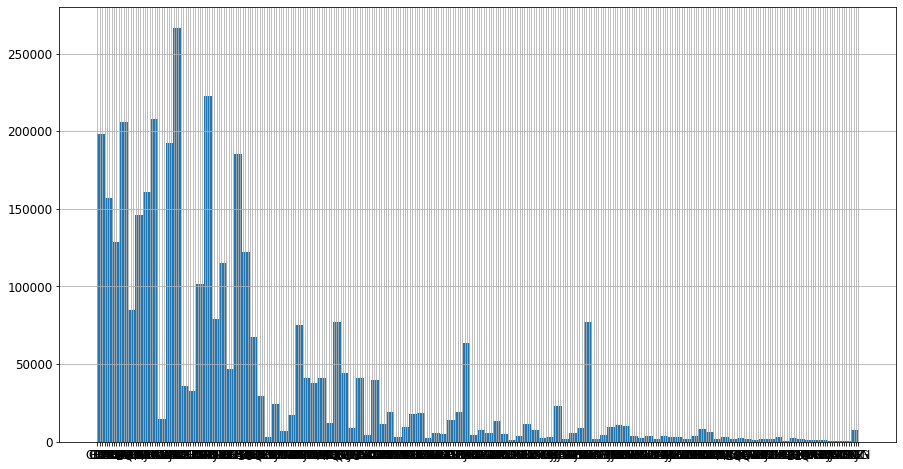

AEROPORT ARRIVEE


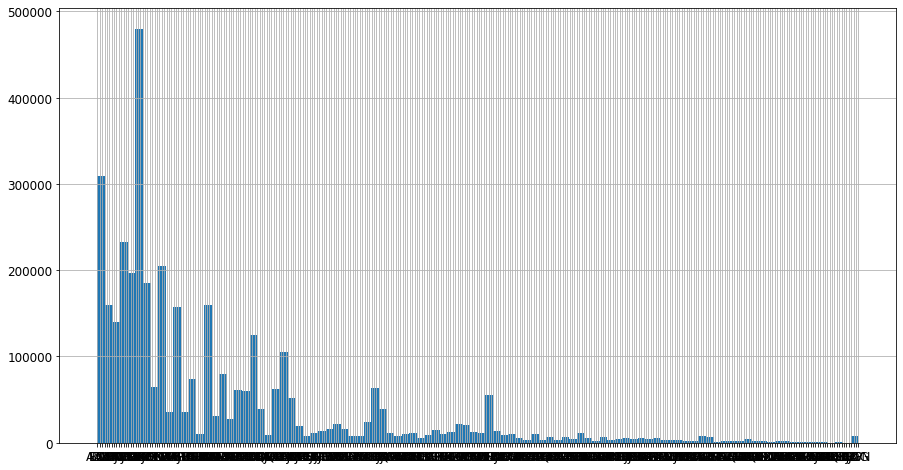

DEPART PROGRAMME


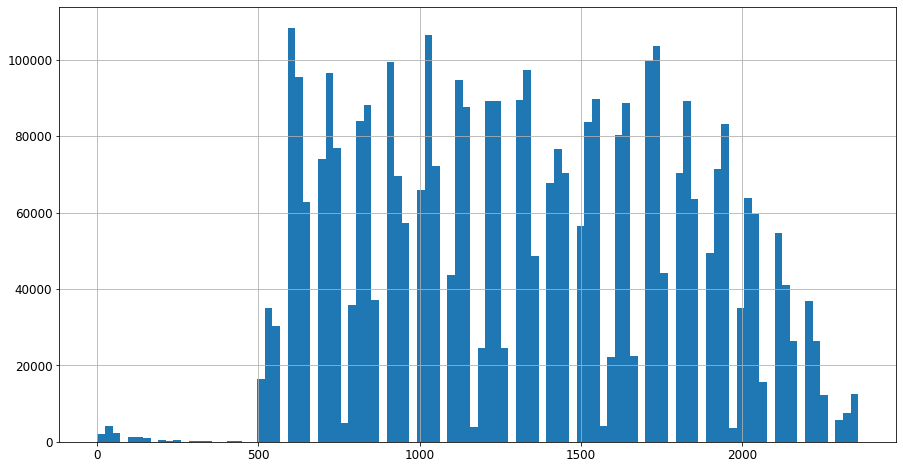

ARRIVEE PROGRAMMEE


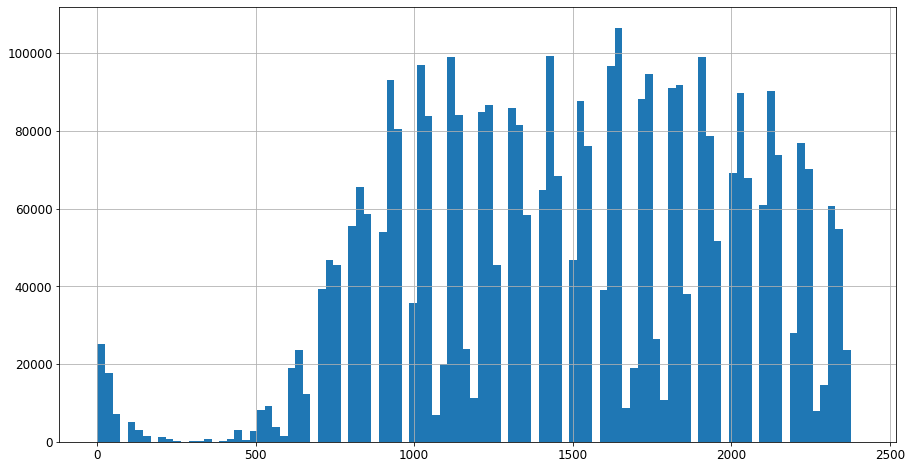

TEMPS PROGRAMME


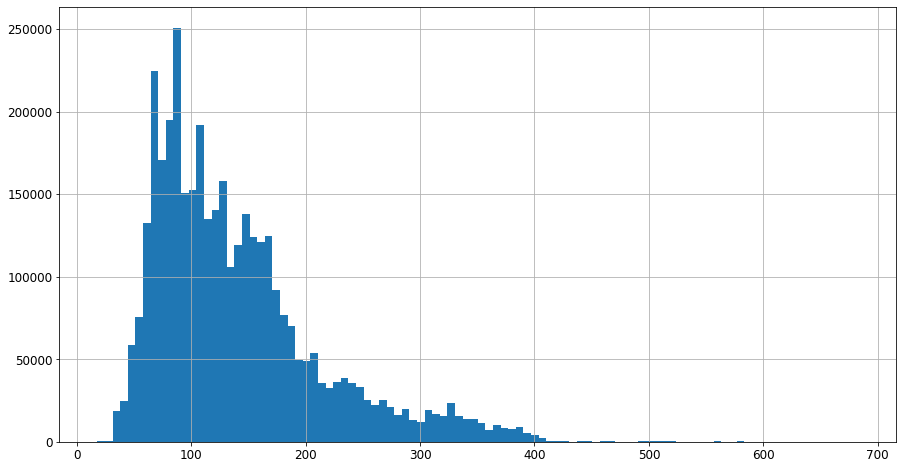

TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE


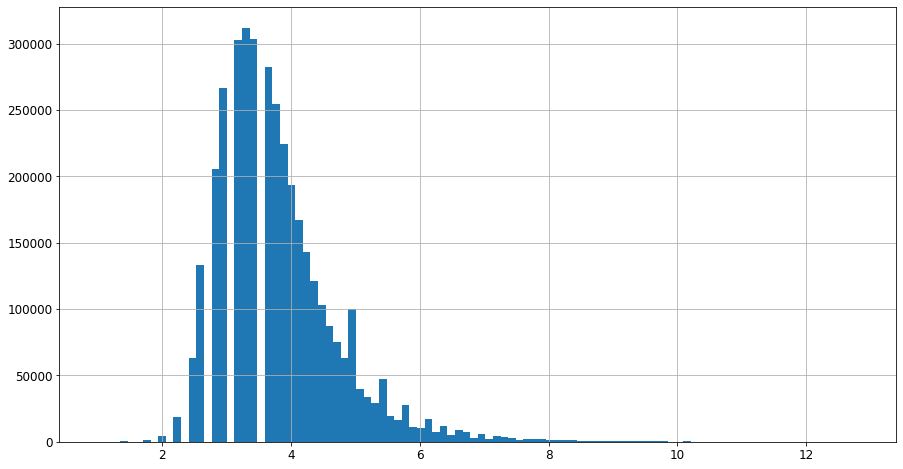

TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE


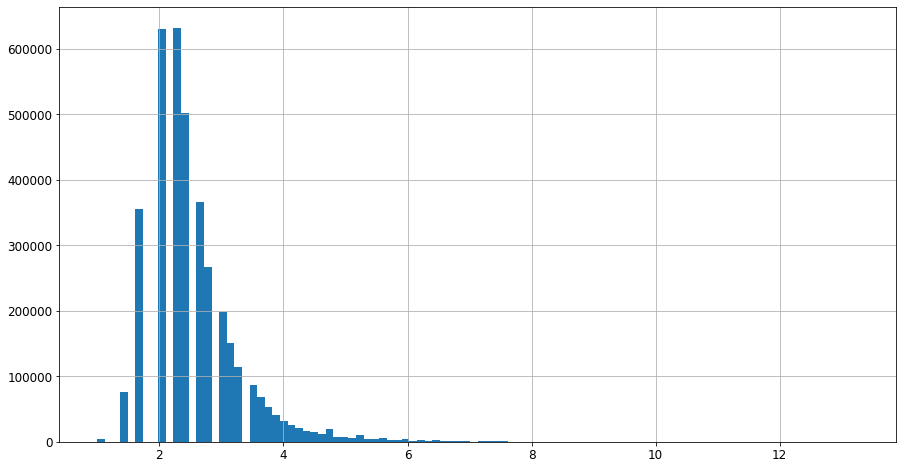

DISTANCE


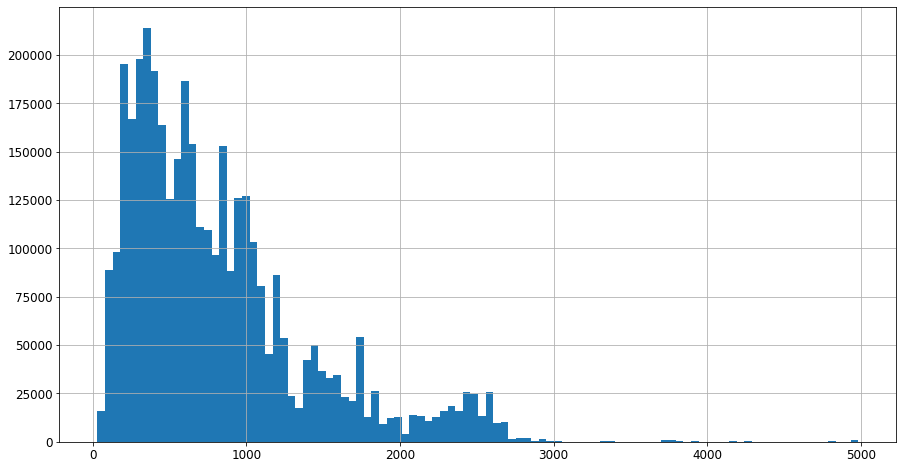

COMPAGNIE AERIENNE


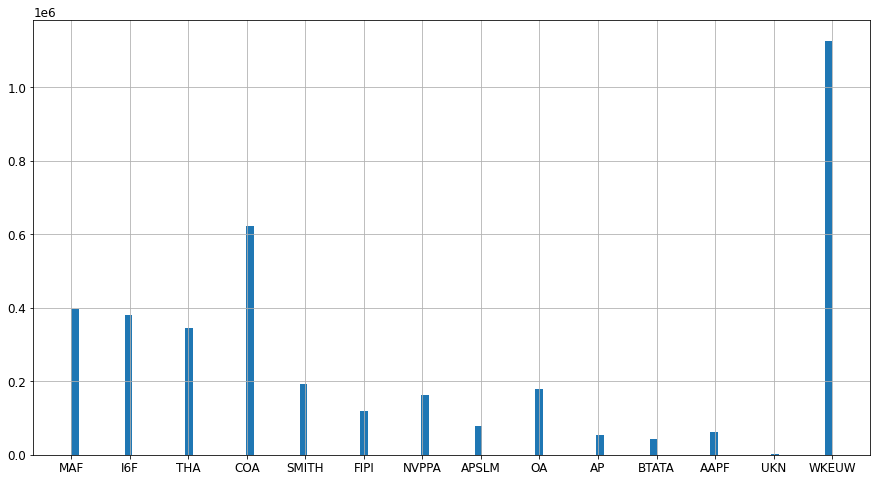

NOMBRE DE PASSAGERS


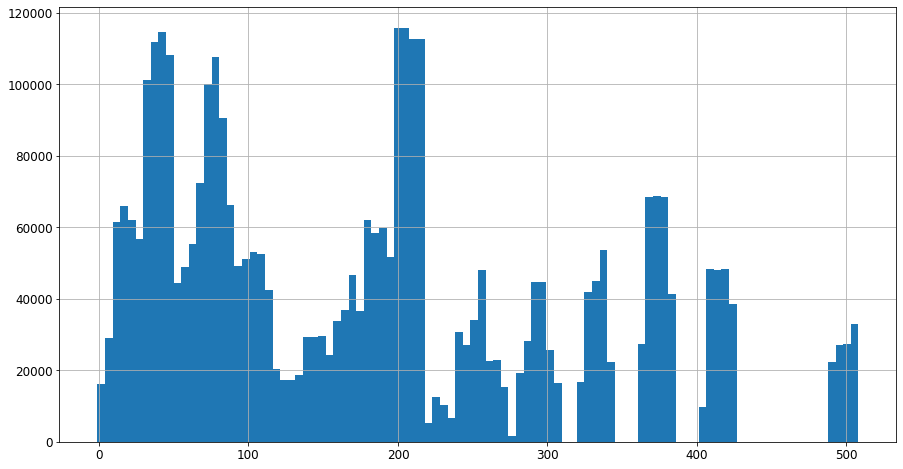

DATE


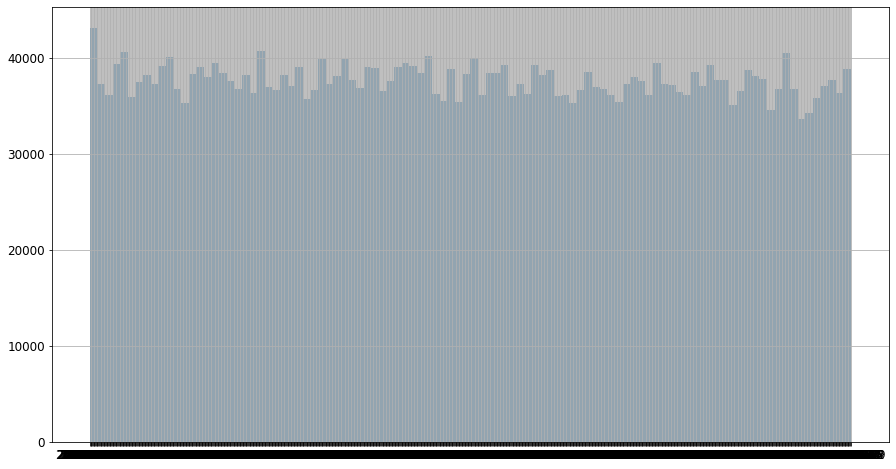

RETARD A L'ARRIVEE


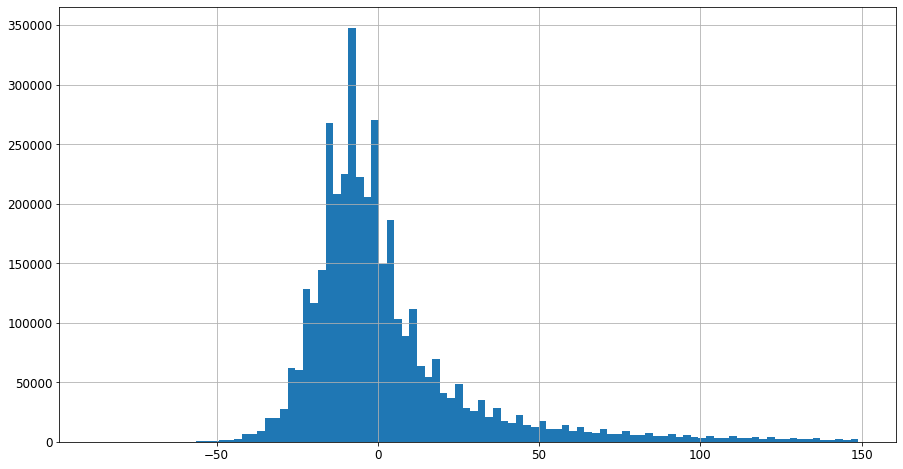

In [24]:
for column in ['AEROPORT DEPART',
                'AEROPORT ARRIVEE',
                'DEPART PROGRAMME',
                'ARRIVEE PROGRAMMEE',
                'TEMPS PROGRAMME',
                'TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE',
                "TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE",
                'DISTANCE',
                'COMPAGNIE AERIENNE',
                'NOMBRE DE PASSAGERS',
                'DATE',
                "RETARD A L'ARRIVEE"]:
    #fig = px.histogram(df_vols_cleaned, x=column, nbins=min(200, df_vols_cleaned[column].nunique()))
    #fig.show()
    print(column)
    df_vols_eng[column].hist(figsize=(15,8), bins=100)
    plt.show();

In [25]:
df_vols_cleaned[df_vols_cleaned['TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE']>150].head()[COLUMNS]

,IDENTIFIANT,VOL,CODE AVION,AEROPORT DEPART,AEROPORT ARRIVEE,DEPART PROGRAMME,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,TEMPS PROGRAMME,DISTANCE,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,ARRIVEE PROGRAMMEE,COMPAGNIE AERIENNE,NOMBRE DE PASSAGERS,DATE,NIVEAU DE SECURITE,RETARD A L'ARRIVEE
14828,3645414,2140,f059c4972e,UPG,DUR,1930,156.0,85.0,399,6.0,2055,COA,32,2017-04-20,10,138.0
16654,1367457,4739,f1e1c02848,DQM,BRU,615,176.0,82.0,308,48.0,737,MAF,263,2018-03-01,10,195.0
49561,4990669,2527,04be892773,DXB,CJU,1005,161.0,90.0,539,3.0,1135,I6F,35,2018-02-27,10,142.0
81212,4284786,2343,7935724dda,DXB,HAJ,2005,173.0,166.0,1067,5.0,2351,COA,209,2016-05-26,10,163.0
103918,3805090,325,eb52f771ca,LTK,SHJ,945,152.0,165.0,733,11.0,1130,COA,208,2016-02-26,10,145.0


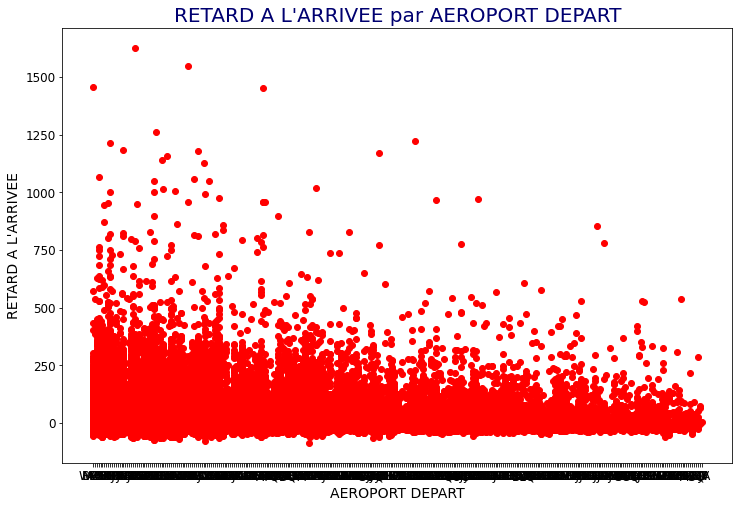

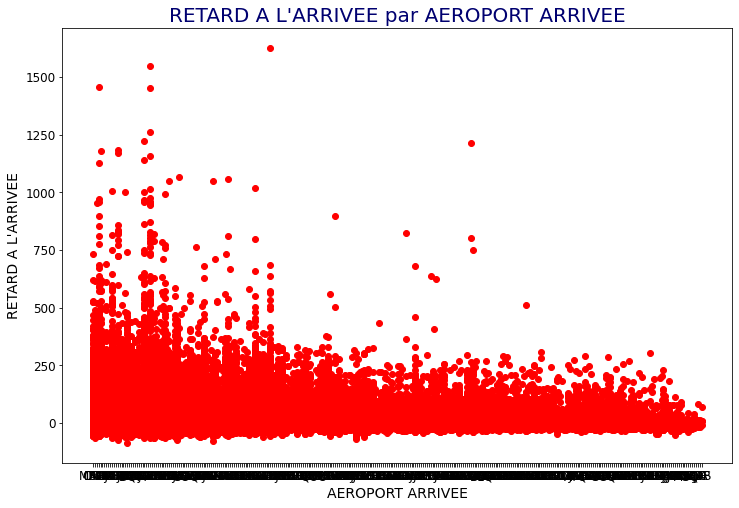

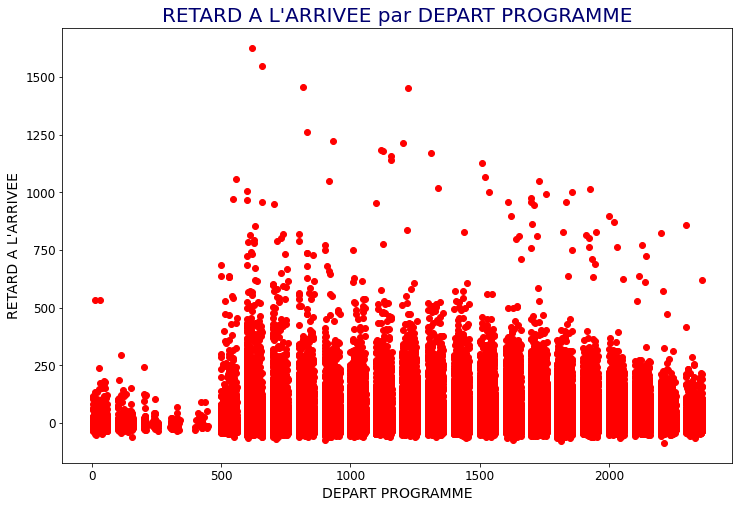

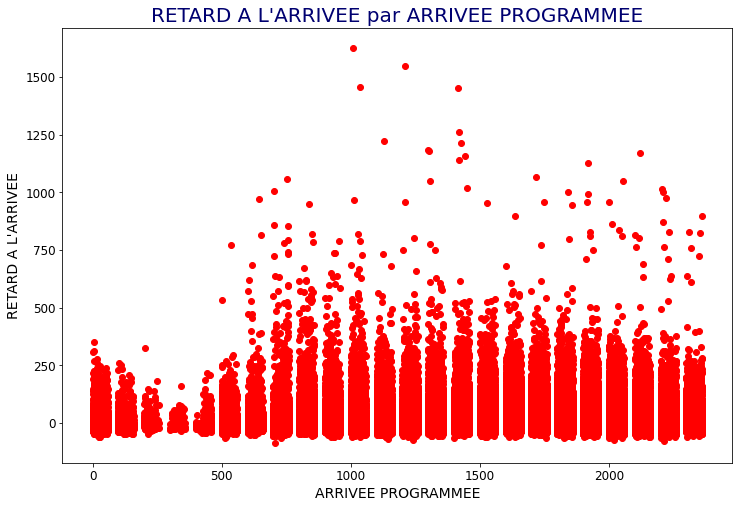

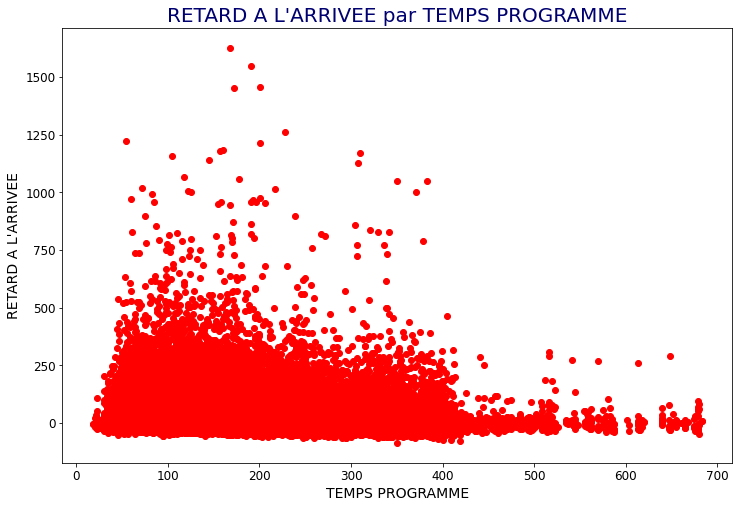

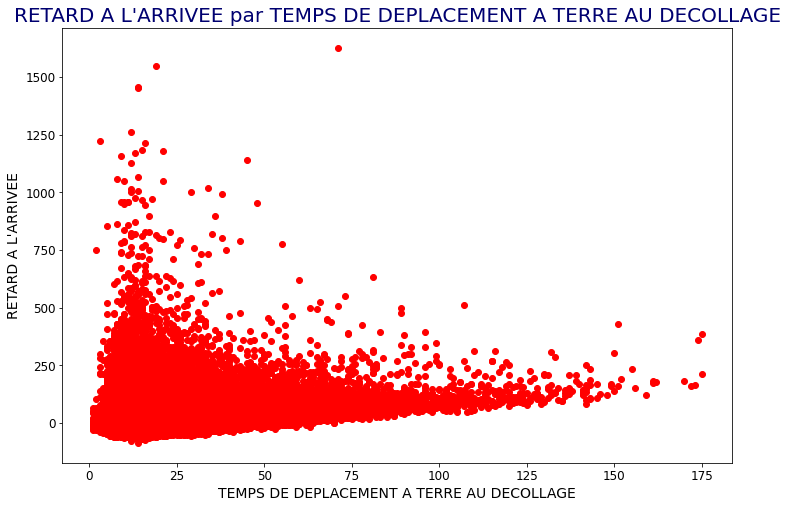

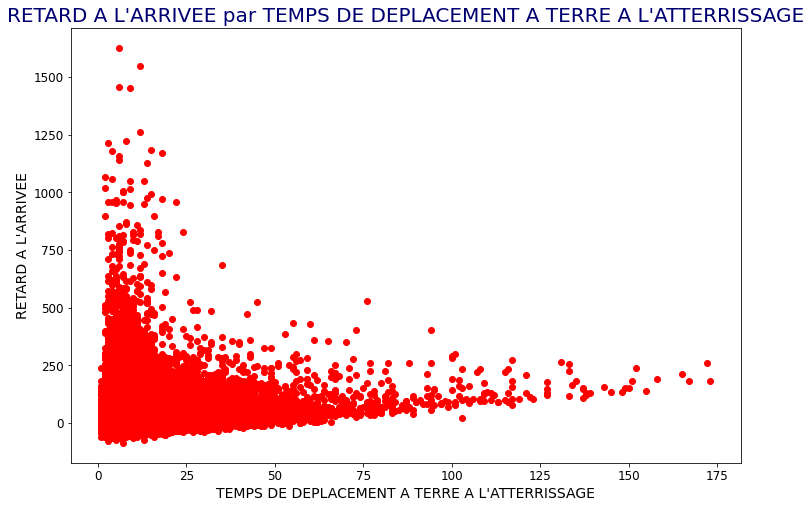

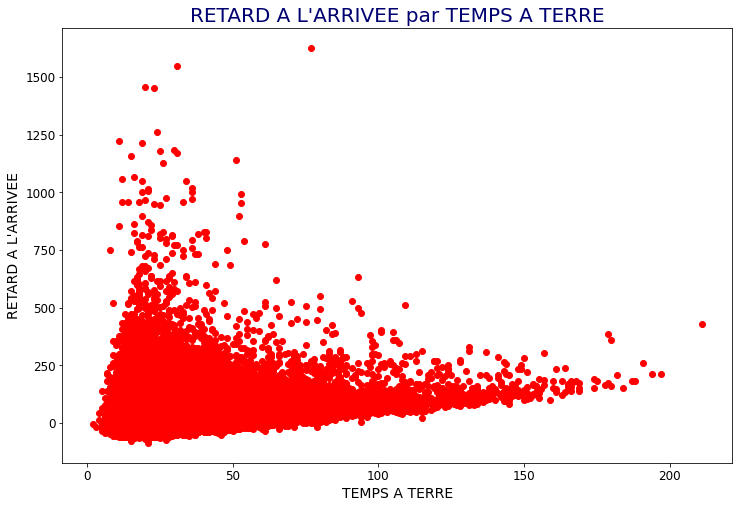

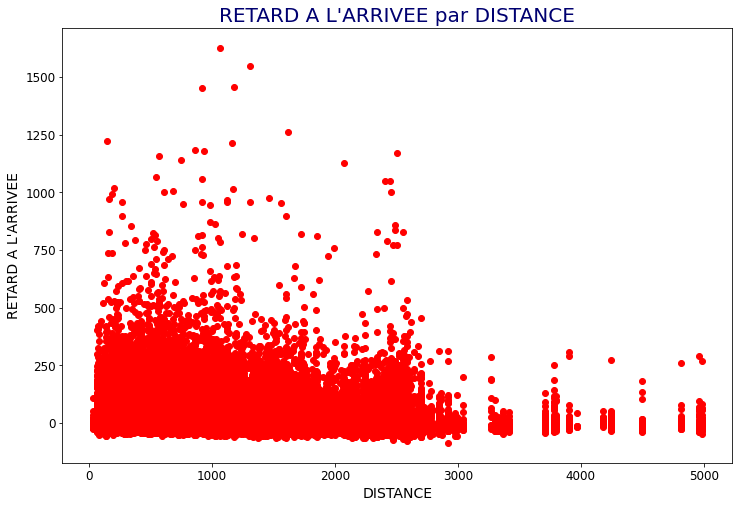

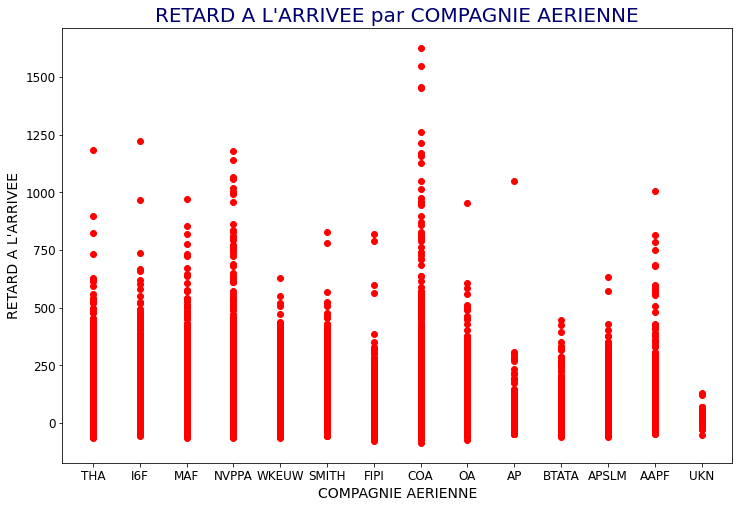

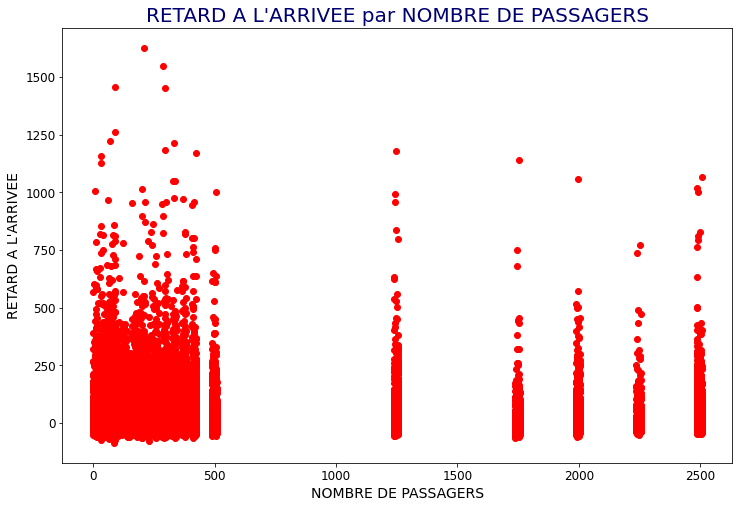

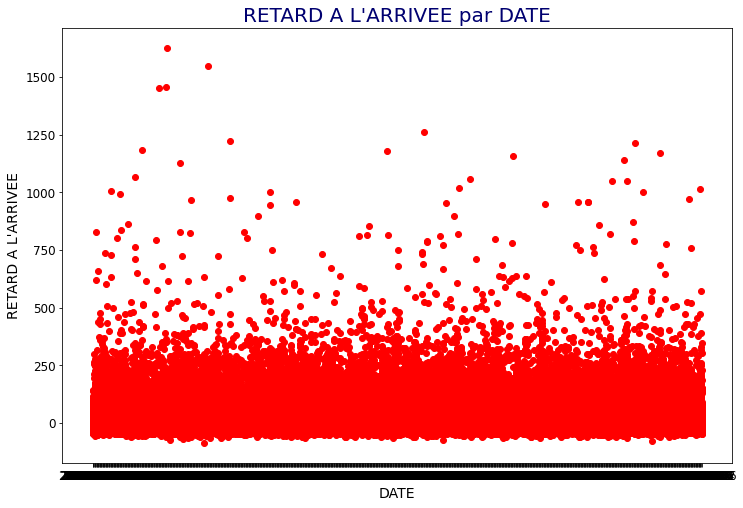

In [26]:
df_vols_cleaned["TEMPS A TERRE"] = df_vols_cleaned['TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE'] +\
    df_vols_cleaned["TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE"]
df_vols_cleaned_smaller = df_vols_cleaned.sample(frac=0.1)

for column in ['AEROPORT DEPART',
                'AEROPORT ARRIVEE',
                'DEPART PROGRAMME',
                'ARRIVEE PROGRAMMEE',
                'TEMPS PROGRAMME',
                'TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE',
                "TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE",
                "TEMPS A TERRE",
                'DISTANCE',
                'COMPAGNIE AERIENNE',
                'NOMBRE DE PASSAGERS',
                'DATE',]:
    plt.close()
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes()

    plt.rcParams.update({'font.size': 15})

    plt.scatter(df_vols_cleaned_smaller[column], df_vols_cleaned_smaller["RETARD A L'ARRIVEE"],
             c='#FF0000')

    plt.title(f"RETARD A L'ARRIVEE par {column}", size=20, color="#000070")

    # Titres des axes
    ax = ax.set(xlabel=column, ylabel="RETARD A L'ARRIVEE")
    plt.show()

### Aeroports

In [27]:
df_aeroports = pd.concat([df_batch1['aeroports'], df_batch2['aeroports']])
df_aeroports.drop_duplicates(inplace = True)

duplicate_airport = df_aeroports.loc[
    df_aeroports.duplicated(subset=['CODE IATA'], keep=False),
    ['CODE IATA', 'PRIX RETARD PREMIERE 20 MINUTES', 'PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES']].groupby(
    by=['CODE IATA']).mean().to_dict(orient='index')

df_aeroports.drop_duplicates(inplace = True, subset=['CODE IATA'])
df_aeroports[df_aeroports['CODE IATA']=='JNB'] # => duplicate on JNB if no subset

,CODE IATA,NOM,LIEU,PAYS,LONGITUDE,LATITUDE,HAUTEUR,PRIX RETARD PREMIERE 20 MINUTES,PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES
238,JNB,OR Tambo International Airport,Johannesburg,ZA,28.246,-26.1392,5558.0,14,2


In [28]:
for code_iata in duplicate_airport.keys():
    df_aeroports.loc[
        df_aeroports['CODE IATA']==code_iata,
        ['PRIX RETARD PREMIERE 20 MINUTES']
    ] = df_aeroports.loc[
        df_aeroports['CODE IATA']==code_iata,
        ['PRIX RETARD PREMIERE 20 MINUTES']
    ].apply(lambda x: duplicate_airport[code_iata]['PRIX RETARD PREMIERE 20 MINUTES'], axis=1)
    
    df_aeroports.loc[
        df_aeroports['CODE IATA']==code_iata,
        ['PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES']
    ] = df_aeroports.loc[
        df_aeroports['CODE IATA']==code_iata,
        ['PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES']
    ].apply(lambda x: duplicate_airport[code_iata]['PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES'], axis=1)

In [29]:
df_aeroports[df_aeroports['CODE IATA']=='JNB'] # => duplicate on JNB if no subset

,CODE IATA,NOM,LIEU,PAYS,LONGITUDE,LATITUDE,HAUTEUR,PRIX RETARD PREMIERE 20 MINUTES,PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES
238,JNB,OR Tambo International Airport,Johannesburg,ZA,28.246,-26.1392,5558.0,46,2


In [30]:
display(df_aeroports.head(20))
display(df_aeroports.shape)

,CODE IATA,NOM,LIEU,PAYS,LONGITUDE,LATITUDE,HAUTEUR,PRIX RETARD PREMIERE 20 MINUTES,PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES
0,MCT,Muscat International Airport,Muscat,OM,58.284400939941406,23.593299865722656,48.0,53,3
1,SOU,Southampton Airport,Southampton,GB,-1.3567999601364136,50.95029830932617,44.0,24,5
2,PNH,Phnom Penh International Airport,Phnom Penh,KH,104.84400177001953,11.546600341796875,40.0,33,3
3,BLR,Kempegowda International Airport,Bangalore,IN,77.706299,13.1979,3000.0,70,9
4,FFD,RAF Fairford,Fairford,GB,-1.7900300025900002,51.6822013855,286.0,65,3
5,CGO,Zhengzhou Xinzheng International Airport,Zhengzhou,CN,113.841003418,34.519699096699995,495.0,46,2
6,DRS,Dresden Airport,Dresden,DE,13.767200469970703,51.1328010559082,755.0,31,6
7,BZZ,RAF Brize Norton,Brize Norton,GB,-1.58362,51.75,288.0,75,8
8,MWX,Muan International Airport,Piseo-ri (Muan),KR,126.382814,34.991406,35.0,50,4
9,DAR,Julius Nyerere International Airport,Dar es Salaam,TZ,39.202599,-6.87811,182.0,88,5


(320, 9)

In [31]:
df_aeroports.info(show_counts=True) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 33
Data columns (total 9 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   CODE IATA                                        320 non-null    object 
 1   NOM                                              320 non-null    object 
 2   LIEU                                             320 non-null    object 
 3   PAYS                                             320 non-null    object 
 4   LONGITUDE                                        320 non-null    object 
 5   LATITUDE                                         320 non-null    object 
 6   HAUTEUR                                          320 non-null    float64
 7   PRIX RETARD PREMIERE 20 MINUTES                  320 non-null    int64  
 8   PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES  320 non-null    int64  
dtypes: float64(1), int64(2), object(6)

In [32]:
df_aeroports.nunique()

CODE IATA                                          320
NOM                                                320
LIEU                                               303
PAYS                                               111
LONGITUDE                                          320
LATITUDE                                           320
HAUTEUR                                            257
PRIX RETARD PREMIERE 20 MINUTES                     89
PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES      9
dtype: int64

In [33]:
df_aeroports.describe()

,HAUTEUR,PRIX RETARD PREMIERE 20 MINUTES,PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES
count,320.00000,320.000000,320.000000
mean,679.99375,52.815625,4.940625
std,1172.74871,24.745230,2.591203
min,6.00000,10.000000,1.000000
25%,58.00000,32.000000,3.000000
50%,218.50000,53.000000,5.000000
75%,681.00000,73.250000,7.000000
max,7630.00000,99.000000,9.000000


In [34]:
df_aeroports['LONGITUDE'] = df_aeroports['LONGITUDE'].astype('float')
df_aeroports['LATITUDE'] = df_aeroports['LATITUDE'].astype('float')

In [35]:
df_aeroports['LONGITUDE TRONQUEE'] = df_aeroports['LONGITUDE'].apply(round)
df_aeroports['LATITUDE TRONQUEE'] = df_aeroports['LATITUDE'].apply(round)

#### Retour sur la df VOLS

In [36]:
airport_dict = df_aeroports.set_index("CODE IATA").to_dict(orient='index')

In [37]:
df_vols_eng.loc[:, 'PAYS DEPART'] = df_vols_eng['AEROPORT DEPART'].apply(lambda x: airport_dict.get(x)['PAYS'])
df_vols_eng.loc[:, 'PAYS ARRIVEE'] = df_vols_eng['AEROPORT ARRIVEE'].apply(lambda x: airport_dict.get(x)['PAYS'])

df_vols_eng.loc[:, 'HAUTEUR DEPART'] = df_vols_eng['AEROPORT DEPART'].apply(lambda x: airport_dict.get(x)['HAUTEUR'])
df_vols_eng.loc[:, 'HAUTEUR ARRIVEE'] = df_vols_eng['AEROPORT ARRIVEE'].apply(lambda x: airport_dict.get(x)['HAUTEUR'])
df_vols_eng.loc[:, 'LONGITUDE ARRIVEE'] = df_vols_eng['AEROPORT ARRIVEE'].apply(lambda x: airport_dict.get(x)['LONGITUDE TRONQUEE'])
df_vols_eng.loc[:, 'LATITUDE ARRIVEE'] = df_vols_eng['AEROPORT ARRIVEE'].apply(lambda x: airport_dict.get(x)['LATITUDE TRONQUEE'])

df_vols_eng.loc[:, 'PRIX RETARD PREMIERE 20 MINUTES'] = df_vols_eng['AEROPORT ARRIVEE'].apply(
    lambda x: airport_dict.get(x)['PRIX RETARD PREMIERE 20 MINUTES'])
df_vols_eng.loc[:, 'PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES'] = df_vols_eng['AEROPORT ARRIVEE'].apply(
    lambda x: airport_dict.get(x)['PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES'])


In [38]:
df_vols_eng

,IDENTIFIANT,VOL,CODE AVION,AEROPORT DEPART,AEROPORT ARRIVEE,DEPART PROGRAMME,HEURE DE DEPART,RETART DE DEPART,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,DECOLLAGE,TEMPS PROGRAMME,TEMPS PASSE,TEMPS DE VOL,DISTANCE,ATTERRISSAGE,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,ARRIVEE PROGRAMMEE,HEURE D'ARRIVEE,RETARD A L'ARRIVEE,DETOURNEMENT,ANNULATION,RAISON D'ANNULATION,RETARD SYSTEM,RETARD SECURITE,RETARD COMPAGNIE,RETARD AVION,RETARD METEO,COMPAGNIE AERIENNE,NOMBRE DE PASSAGERS,DATE,NIVEAU DE SECURITE,PAYS DEPART,PAYS ARRIVEE,HAUTEUR DEPART,HAUTEUR ARRIVEE,LONGITUDE ARRIVEE,LATITUDE ARRIVEE,PRIX RETARD PREMIERE 20 MINUTES,PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES
0,1259209,4661,a02782cd75,CEB,AAL,1707,1658.0,-9.0,4.472136,1718.0,67.0,71.0,45.0,232,1803.0,2.449490,1814,1809.0,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,MAF,379,2018-08-15,10,PH,DK,31.0,10.0,10,57,17,9
1,4886177,5026,707f6ea54f,GOI,LTK,600,553.0,-7.0,3.316625,604.0,130.0,119.0,91.0,738,835.0,4.123106,910,852.0,-18.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,I6F,9,2016-02-11,10,IN,SY,150.0,157.0,36,35,90,7
4,2157498,508,34604053c0,BRU,BOD,612,603.0,-9.0,3.605551,616.0,302.0,259.0,238.0,2288,1314.0,2.828427,1414,1322.0,-52.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,THA,78,2018-10-11,10,BE,FR,184.0,162.0,-1,45,13,4
6,4016340,1627,c942b5536a,PEK,DXB,645,643.0,-2.0,4.123106,700.0,193.0,168.0,142.0,1205,1122.0,3.000000,1158,1131.0,-27.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,COA,364,2016-08-09,10,CN,AE,116.0,62.0,55,25,93,9
7,1834318,525,04338f33e4,CPH,SXF,1555,1607.0,12.0,3.000000,1616.0,132.0,114.0,100.0,679,1756.0,2.236068,1807,1801.0,-6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,THA,369,2016-06-26,10,DK,DE,17.0,157.0,14,52,91,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332909,5255349,3306,1558121ece,DXB,CDG,1830,1956.0,86.0,5.291503,2024.0,171.0,162.0,127.0,977,2231.0,2.645751,2121,2238.0,77.0,0,0,NaN,0.0,0.0,0.0,77.0,0.0,SMITH,193,2017-12-27,10,AE,FR,62.0,392.0,3,49,32,8
1332910,5255350,3306,83f05c683c,DXB,CDG,1830,1838.0,8.0,3.605551,1851.0,171.0,140.0,123.0,977,2054.0,2.000000,2121,2058.0,-23.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SMITH,195,2017-12-28,10,AE,FR,62.0,392.0,3,49,32,8
1332911,5255351,3306,83f05c683c,DXB,CDG,1830,1825.0,-5.0,4.358899,1844.0,171.0,147.0,118.0,977,2042.0,3.162278,2121,2052.0,-29.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SMITH,197,2016-12-29,10,AE,FR,62.0,392.0,3,49,32,8
1332912,5255352,3306,89b2dba862,DXB,CDG,1830,1825.0,-5.0,3.605551,1838.0,171.0,149.0,128.0,977,2046.0,2.828427,2121,2054.0,-27.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SMITH,201,2017-12-30,10,AE,FR,62.0,392.0,3,49,32,8


PAYS DEPART


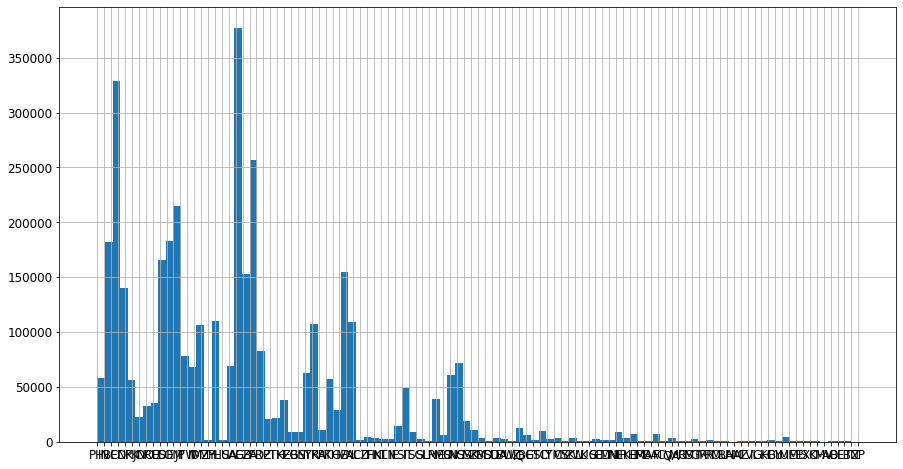

PAYS ARRIVEE


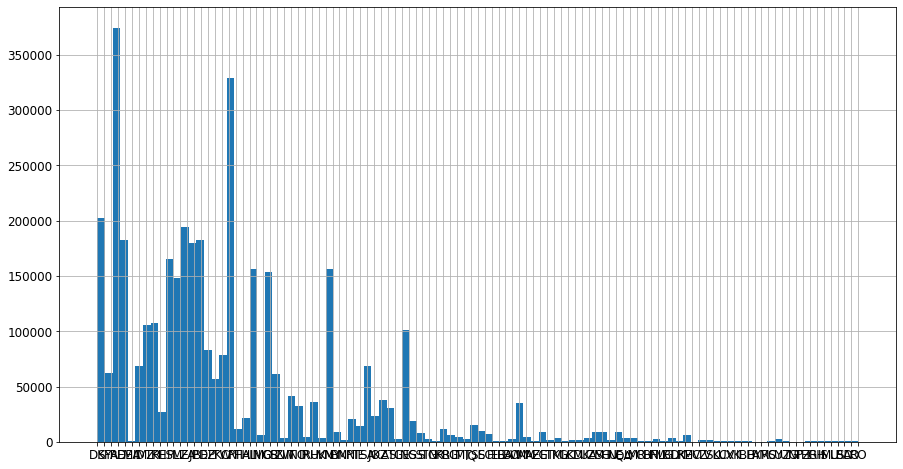

HAUTEUR DEPART


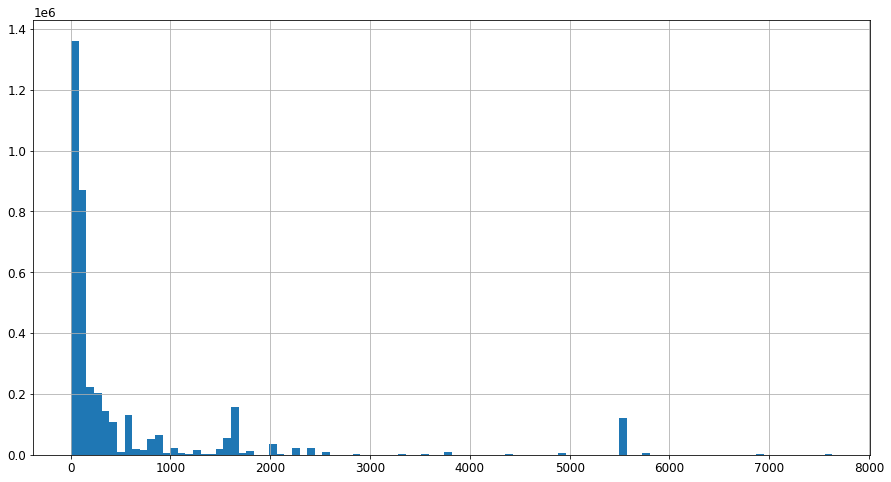

HAUTEUR ARRIVEE


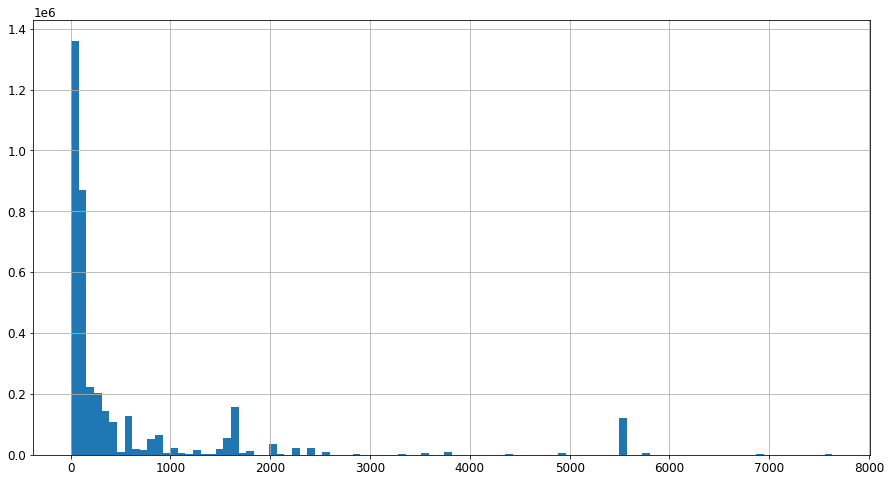

LONGITUDE ARRIVEE


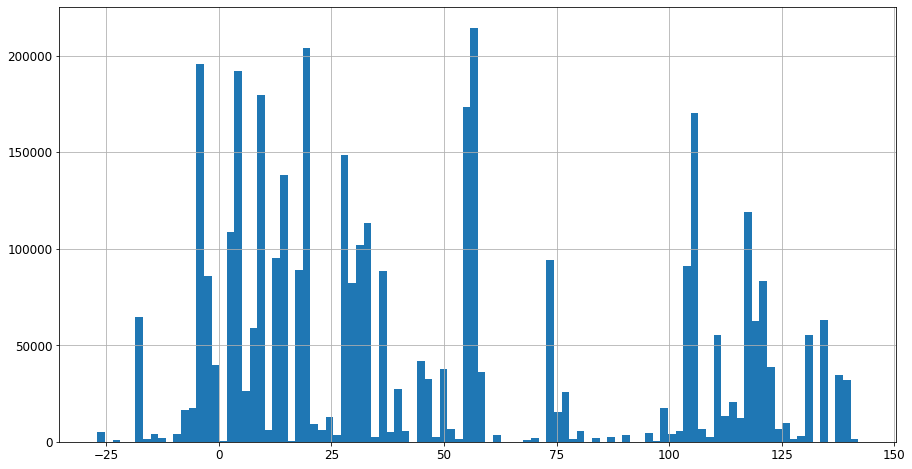

LATITUDE ARRIVEE


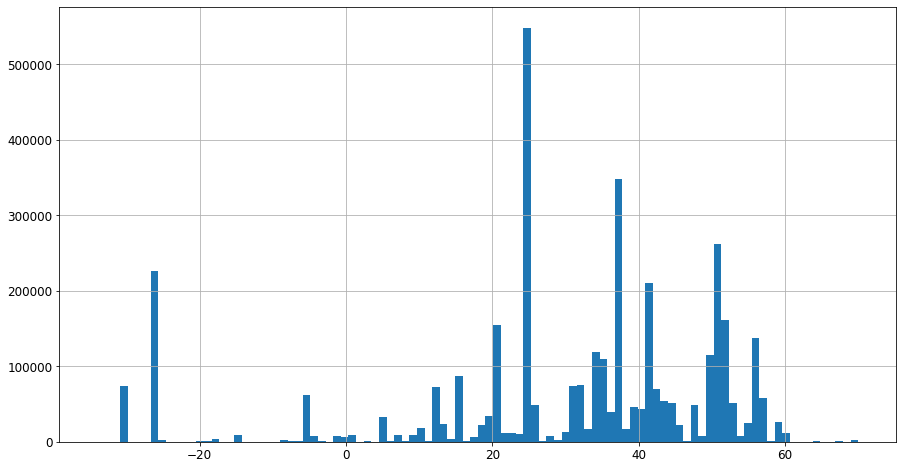

PRIX RETARD PREMIERE 20 MINUTES


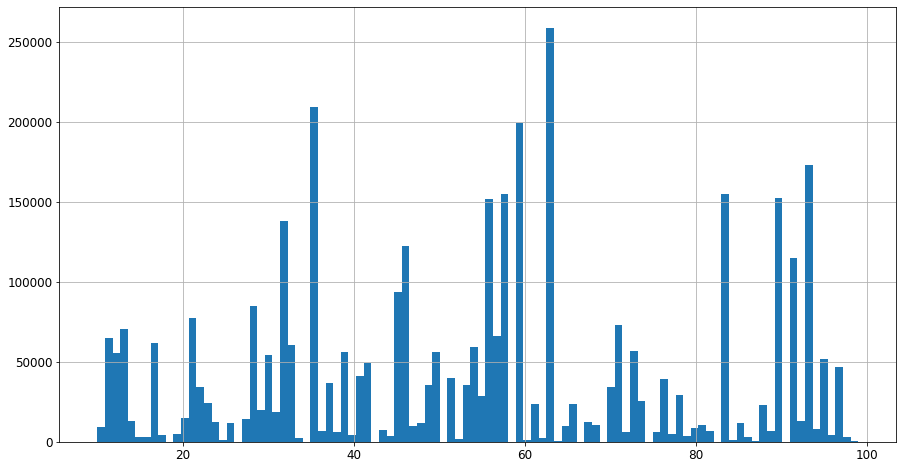

PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES


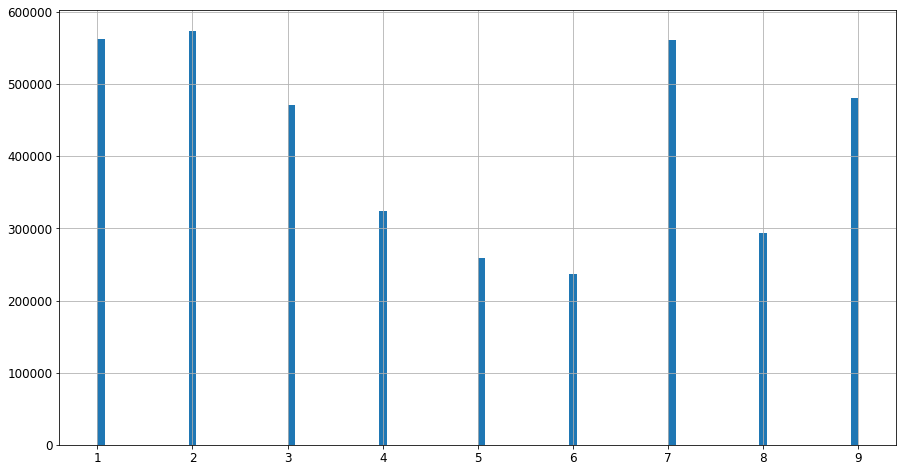

In [39]:
for column in ['PAYS DEPART',
               'PAYS ARRIVEE',
               'HAUTEUR DEPART',
               'HAUTEUR ARRIVEE',
               'LONGITUDE ARRIVEE',
               'LATITUDE ARRIVEE',
               'PRIX RETARD PREMIERE 20 MINUTES',
               'PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES'
              ]:
    print(column)
    df_vols_eng[column].hist(figsize=(15,8), bins=100)
    plt.show();

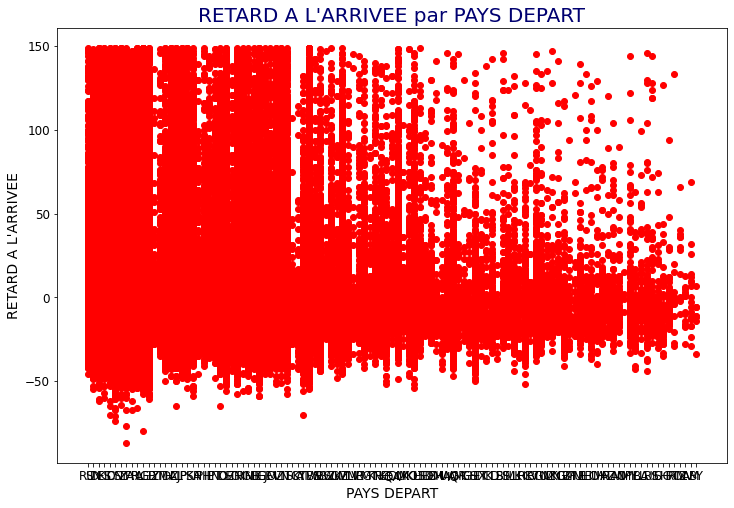

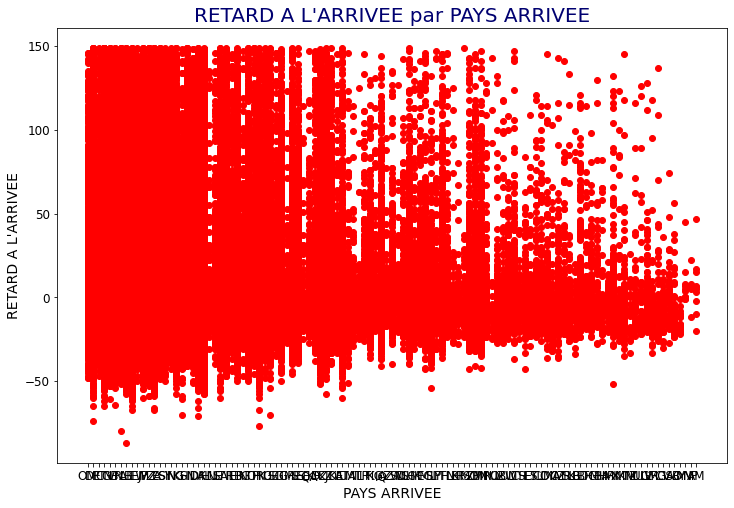

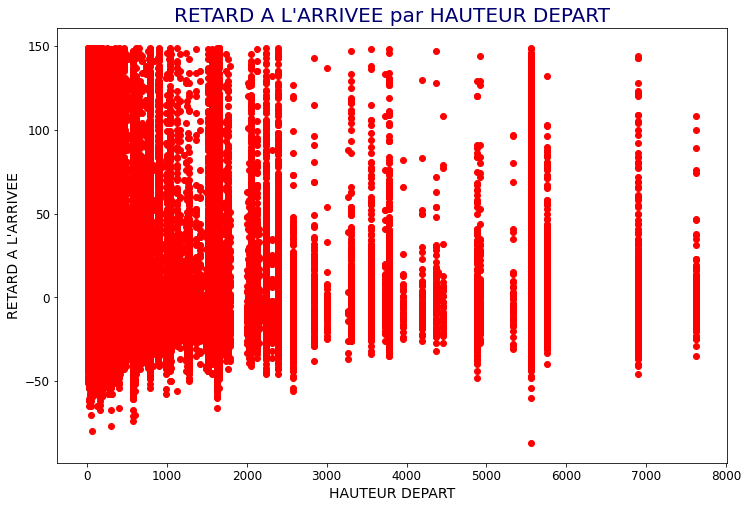

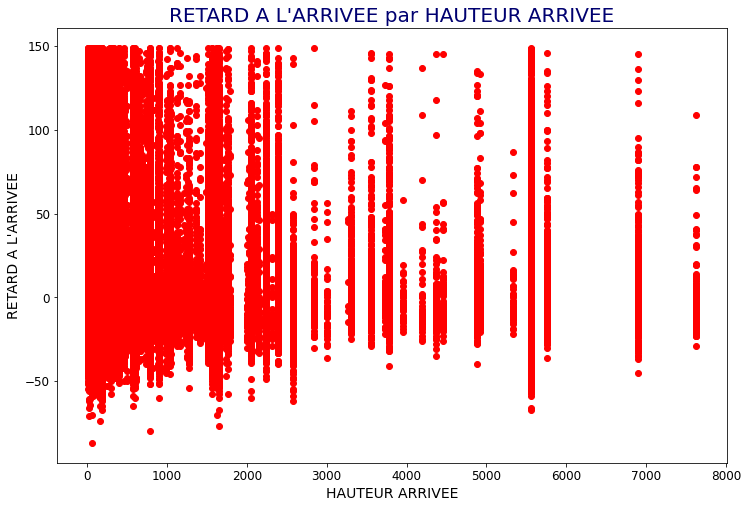

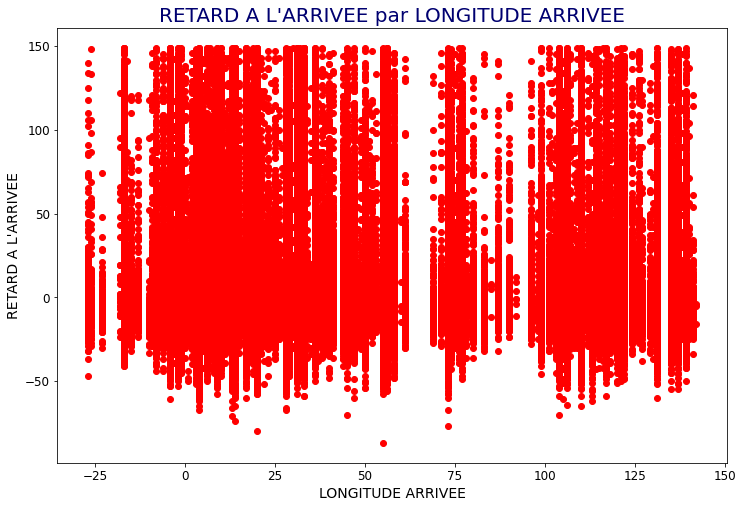

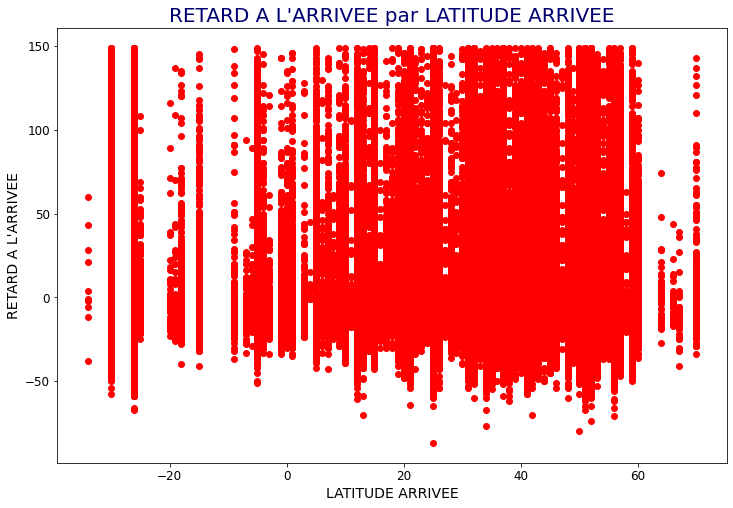

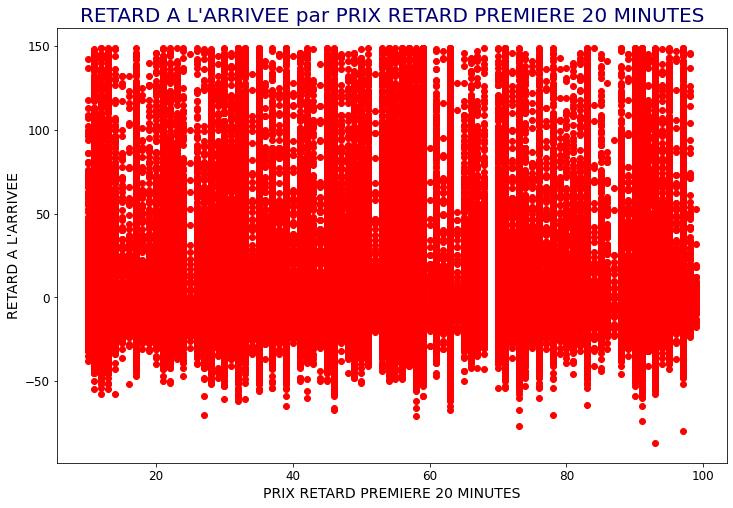

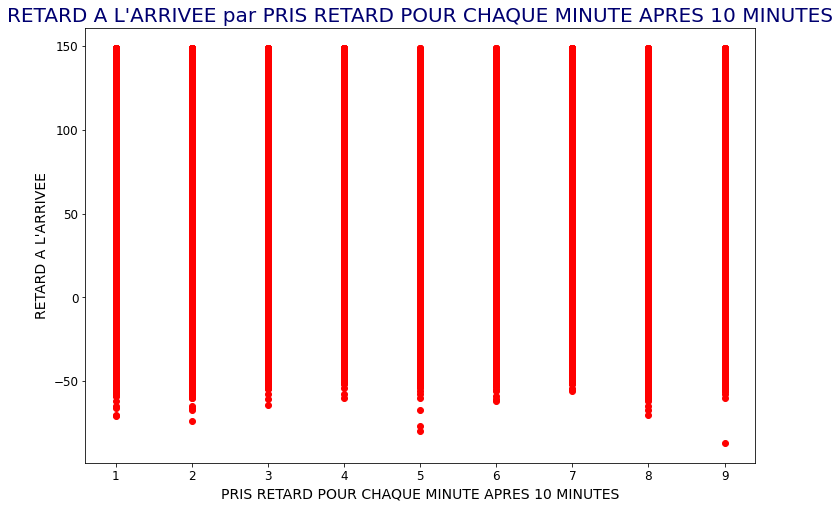

In [40]:
df_vols_eng_smaller = df_vols_eng.sample(frac=0.1)

for column in ['PAYS DEPART',
               'PAYS ARRIVEE',
               'HAUTEUR DEPART',
               'HAUTEUR ARRIVEE',
               'LONGITUDE ARRIVEE',
               'LATITUDE ARRIVEE',
               'PRIX RETARD PREMIERE 20 MINUTES',
               'PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES']:
    plt.close()
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes()

    plt.rcParams.update({'font.size': 15})

    plt.scatter(df_vols_eng_smaller[column], df_vols_eng_smaller["RETARD A L'ARRIVEE"],
             c='#FF0000')

    plt.title(f"RETARD A L'ARRIVEE par {column}", size=20, color="#000070")

    # Titres des axes
    ax = ax.set(xlabel=column, ylabel="RETARD A L'ARRIVEE")
    plt.show()

### Compagnies

In [41]:
df_compagnies1 = pd.concat([df_batch1['compagnies'], df_batch2['compagnies']]).drop_duplicates()
display(df_compagnies1)
display(df_compagnies1.shape)

,COMPAGNIE,CODE,NOMBRE D EMPLOYES,CHIFFRE D AFFAIRE
0,Try Hard Airlines,THA,12909,2310000000
1,Corporate Overlord Airways,COA,130595,40579000000
2,Neverland Airlines,NA,18567,7651000000
3,Always A Problem Flights,AAPF,92000,51000000000
4,Overpriced Air,OA,12200,6649000000
5,Morally Ambiguious Fligthts,MAF,15150,6391000000
6,Fliying Is Possible Inc.,FIPI,13230,2979000000
7,Air Piloter Sans Les Mains,APSLM,13112,7651000000
8,Ne Va Pas Partout Airlines,NVPPA,12000,6235000000
9,IE 6.0 Flights,I6F,17569,2660000000


(14, 4)

### Prix du fuel

## Test

In [42]:
df_test_vols

,IDENTIFIANT,VOL,CODE AVION,AEROPORT DEPART,AEROPORT ARRIVEE,DEPART PROGRAMME,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,TEMPS PROGRAMME,DISTANCE,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,ARRIVEE PROGRAMMEE,COMPAGNIE AERIENNE,NOMBRE DE PASSAGERS,DATE,NIVEAU DE SECURITE
0,664737,1358,aef0a3756b,DXB,DSS,910,18.0,163.0,986,7.0,1253,NVPPA,2499,23/7/2017,10
1,4267541,1912,d96a073a67,TNA,PNH,2015,21.0,222.0,1449,8.0,2157,COA,424,21/8/2016,10
2,4499554,970,0525832a1d,HAN,WRO,2330,13.0,225.0,1703,9.0,515,APSLM,21,30/4/2017,10
3,1666738,2945,dcc04ff515,JNB,MLA,950,45.0,97.0,438,2.0,1127,MAF,67,22/11/2016,10
4,553232,1399,771d982852,DUB,KIX,1205,9.0,79.0,422,3.0,1424,NVPPA,1249,14/2/2018,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1577720,2977,67548cd2a4,JNB,SOQ,1945,15.0,69.0,261,6.0,1954,MAF,301,15/12/2016,10
999996,4938646,4752,6545d2b9d5,SHJ,VCE,2225,17.0,56.0,173,4.0,2321,I6F,82,23/9/2018,10
999997,1336875,2841,92ea6e9f3d,PUS,SHJ,1825,12.0,119.0,567,16.0,1924,MAF,377,5/6/2016,10
999998,180419,2474,756a7b5c57,KWL,JNB,815,54.0,336.0,2153,3.0,1051,NVPPA,1245,29/5/2017,10


In [43]:
df_test_vols_cleaned = data_cleaning.transform(df_test_vols)
df_test_vols_cleaned.loc[:, 'DATE'] = pd.to_datetime(df_test_vols_cleaned['DATE'])

# DATAVIZ